In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, models, transforms
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os

In [2]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(40),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Load datasets
train_dir = 'train'  # Replace with actual path
dataset = datasets.ImageFolder(train_dir, transform=transform)

# Split dataset into training and validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [3]:
# Encode class labels
label_encoder = LabelEncoder()
class_labels = dataset.classes
encoded_labels = label_encoder.fit_transform(class_labels)

# Save the label encoder for later use
import joblib
joblib.dump(label_encoder, 'label_encoder.pkl')

['label_encoder.pkl']

In [4]:
# Load pre-trained InceptionV3 model
model = models.inception_v3(pretrained=True)

# Modify the final layer for our classification task
num_classes = len(encoded_labels)
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, num_classes),
    nn.LogSoftmax(dim=1)
)
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

c:\Users\Sundar\OneDrive\Documents\Projects\Facial Skin disease\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Sundar\OneDrive\Documents\Projects\Facial Skin disease\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20):
    train_acc, val_acc = [], []
    train_loss, val_loss = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            if isinstance(outputs, tuple):
                outputs = outputs[0]  # Use only the primary output
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss.append(running_loss / len(train_loader))
        train_acc.append(correct / total)

        # Validation
        model.eval()
        running_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                if isinstance(outputs, tuple):
                    outputs = outputs[0]  # Use only the primary output
                loss = criterion(outputs, labels)

                running_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_loss.append(running_loss / len(val_loader))
        val_acc.append(correct / total)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss[-1]:.4f}, Train Acc: {train_acc[-1]:.4f}, Val Loss: {val_loss[-1]:.4f}, Val Acc: {val_acc[-1]:.4f}")

    return train_loss, train_acc, val_loss, val_acc

train_loss, train_acc, val_loss, val_acc = train_model(model, train_loader, val_loader, criterion, optimizer)

Epoch 1/20, Train Loss: 1.3401, Train Acc: 0.4368, Val Loss: 1.9458, Val Acc: 0.4114
Epoch 2/20, Train Loss: 1.1433, Train Acc: 0.5464, Val Loss: 1.1111, Val Acc: 0.5418
Epoch 3/20, Train Loss: 0.9883, Train Acc: 0.6059, Val Loss: 1.8838, Val Acc: 0.5819
Epoch 4/20, Train Loss: 0.8830, Train Acc: 0.6636, Val Loss: 0.7944, Val Acc: 0.7124
Epoch 5/20, Train Loss: 0.6964, Train Acc: 0.7490, Val Loss: 0.6912, Val Acc: 0.7559
Epoch 6/20, Train Loss: 0.6072, Train Acc: 0.7732, Val Loss: 0.7181, Val Acc: 0.7692
Epoch 7/20, Train Loss: 0.6017, Train Acc: 0.7874, Val Loss: 0.7352, Val Acc: 0.7793
Epoch 8/20, Train Loss: 0.5381, Train Acc: 0.8151, Val Loss: 0.5646, Val Acc: 0.8194
Epoch 9/20, Train Loss: 0.4645, Train Acc: 0.8326, Val Loss: 0.4118, Val Acc: 0.8462
Epoch 10/20, Train Loss: 0.3884, Train Acc: 0.8736, Val Loss: 0.6679, Val Acc: 0.7592
Epoch 11/20, Train Loss: 0.4588, Train Acc: 0.8343, Val Loss: 0.5377, Val Acc: 0.8495
Epoch 12/20, Train Loss: 0.3975, Train Acc: 0.8611, Val Loss: 0

In [6]:
# Save the model
torch.save(model.state_dict(), 'skin_disease_model.pth')

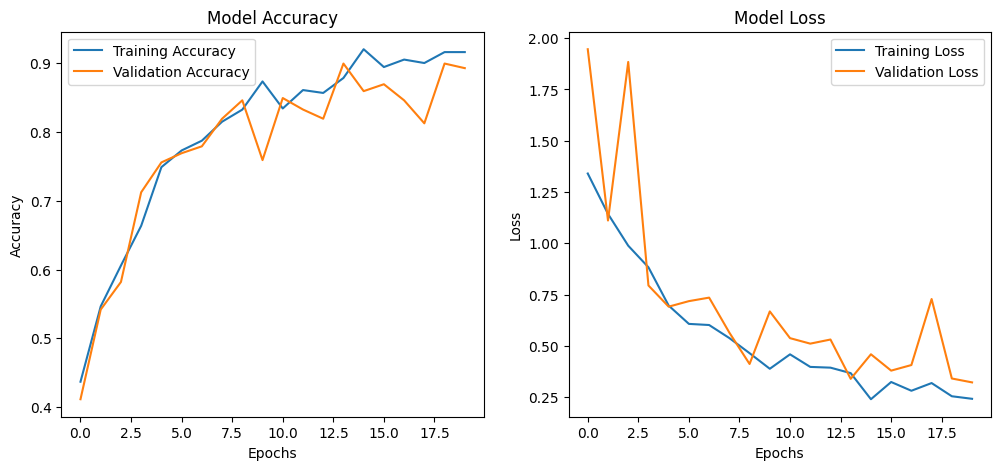

In [7]:
# Plot training history
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

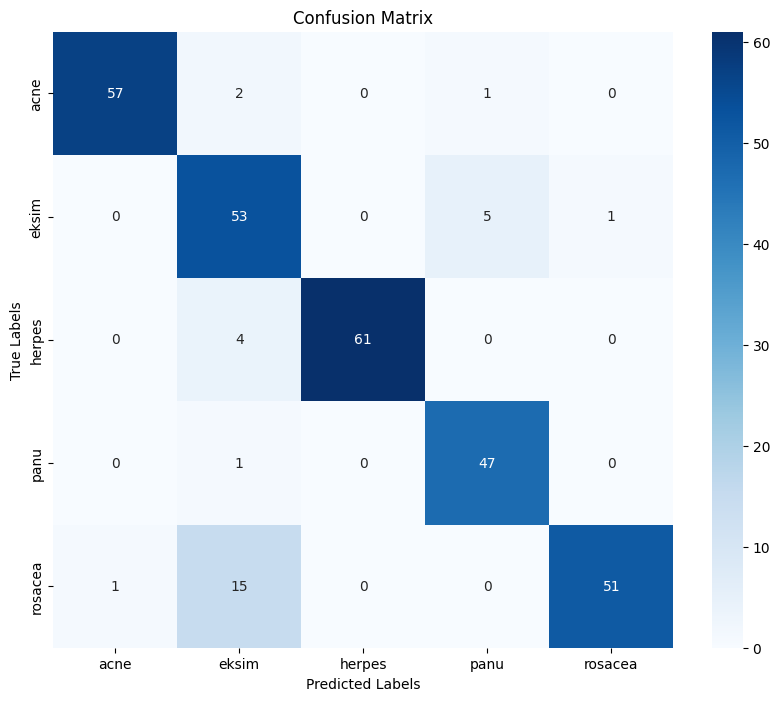

              precision    recall  f1-score   support

        acne       0.98      0.95      0.97        60
       eksim       0.71      0.90      0.79        59
      herpes       1.00      0.94      0.97        65
        panu       0.89      0.98      0.93        48
     rosacea       0.98      0.76      0.86        67

    accuracy                           0.90       299
   macro avg       0.91      0.91      0.90       299
weighted avg       0.92      0.90      0.90       299



In [8]:
# Evaluate on validation set
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Classification report
print(classification_report(all_labels, all_preds, target_names=class_labels))